# Курсовой проект

Задание для курсового проекта Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score) Сдача проекта: Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт). Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний)

Загружаем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats


# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

Игнорируем предупреждения

In [25]:
import warnings
warnings.filterwarnings('ignore')

Загружаем необходимые функции

In [2]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

Загрузим данные

In [4]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')
print("Data is loaded!")

Data is loaded!


In [5]:
print(f"Train:\t{train.shape[0]}\t sales and {train.shape[1]} features")
print(f'Test:\t{test.shape[0]}\t sales and {test.shape[1]} features')

Train:	10000	 sales and 20 features
Test:	5000	 sales and 19 features


In [6]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [7]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [8]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [9]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Оптимизируем использование памяти

In [10]:
train['Rooms'] = train['Rooms'].astype('int64')
test['Rooms'] = test['Rooms'].astype('int64')

In [11]:
train['HouseFloor'] = train['HouseFloor'].astype('int64')
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [12]:
train = optimizing_df(train)
test = optimizing_df(test)

In [13]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  uint8   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  uint8   
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

In [14]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   uint16  
 1   DistrictId     5000 non-null   uint8   
 2   Rooms          5000 non-null   uint8   
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   uint8   
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   uint8   
 17  Shops_1        5000 non-null   ui

Проверим данные

In [15]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [16]:
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,15000.0,8393.136933,4850.111673,0.000000,4188.750000,8378.500000,12594.250000,1.679800e+04
DistrictId,15000.0,50.693600,43.786257,0.000000,20.000000,37.000000,75.000000,2.120000e+02
Rooms,15000.0,1.897000,0.839229,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,15000.0,56.360554,20.423906,1.136859,41.814370,52.645758,66.036606,6.410652e+02
LifeSquare,11846.0,36.851757,71.120193,0.333490,22.896130,32.822811,45.144627,7.480592e+03
KitchenSquare,15000.0,6.174467,24.017342,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,15000.0,8.561800,5.323113,1.000000,4.000000,7.000000,12.000000,7.800000e+01
HouseFloor,15000.0,12.606600,6.780165,0.000000,9.000000,12.000000,17.000000,1.170000e+02
HouseYear,15000.0,3321.575067,163707.780381,1908.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,15000.0,0.119195,0.119371,0.000000,0.017647,0.075424,0.195781,5.218670e-01


Исправим комнаты

In [17]:
all_data.loc[all_data['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2004,5927,57,10,59.056976,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B
2728,14865,9,10,60.871265,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B
6088,8491,1,19,42.006046,21.779287,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B
11981,1435,111,17,52.866108,32.528343,8.0,15,17,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [18]:
all_data.loc[all_data['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2194,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B
3780,7317,27,0,41.790882,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
5894,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B
6401,9443,27,0,87.762619,85.125473,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
7644,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
7929,456,6,0,81.491447,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
9767,12638,27,0,138.427689,136.215500,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B
9869,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
10961,3343,58,0,116.824203,113.692421,0.0,3,3,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
14179,10729,27,0,76.345154,42.820797,12.0,14,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


In [19]:
def df_fix_room(df):
    info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_roos_dr', 'Square': 'sum_square_dr'})

    info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_roos_dr']
    info_by_district_id.drop(
        ['sum_square_dr', 'sum_roos_dr'], axis=1, inplace=True)

    df = pd.merge(df, info_by_district_id, on=[
                  'DistrictId', 'HouseYear'], how='left')

    df['mean_square_per_room_in_dr'] = df['mean_square_per_room_in_dr'].fillna(
        df['mean_square_per_room_in_dr'].mean())

    df.loc[df['Rooms'] > 6, 'Rooms'] \
        = (df.loc[df['Rooms'] > 6, 'Square']
           // df.loc[df['Rooms'] > 6, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] \
        = (df.loc[df['Rooms'] == 0, 'Square']
           // df.loc[df['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    return df

Исправим площадь

In [20]:
all_data.loc[all_data['Square'] > 200].nlargest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
9229,11602,30,2,641.065186,638.163208,10.0,20,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B
726,28,9,2,604.705994,NaN,1.0,17,18,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
7010,2307,102,1,409.425171,410.639740,10.0,4,4,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
1906,5548,86,5,275.645294,233.949310,26.0,12,37,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B
10956,4058,27,6,223.453690,104.113556,16.0,2,2,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
14402,1397,76,3,221.138763,118.055344,4.0,32,48,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B
7644,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
1776,16568,27,4,200.334534,201.627365,25.0,1,2,2013,0.041116,B,B,53,14892,4,NaN,1,4,B


mu = 56.36 and sigma = 20.42


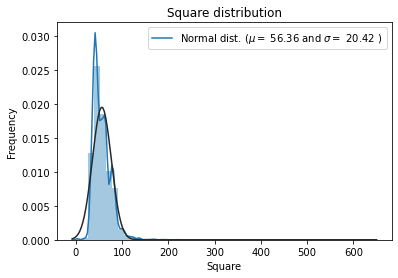

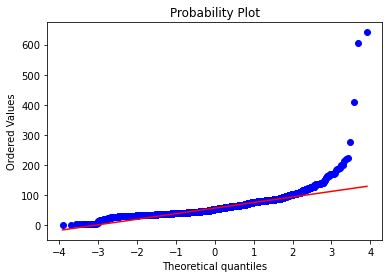

In [26]:
sns.distplot(all_data['Square'], fit=norm)

mu, sigma = norm.fit(all_data['Square'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'])
plt.ylabel('Frequency')
plt.title('Square distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['Square'], plot=plt)
plt.show()

In [27]:
def df_fix_square_manual(df):
    df.loc[df['Square'] > 400, 'Square'] = df.loc[df['Square'] > 400, 'Square'] / 10
    return df

In [28]:
def df_fix_square(df):
    info_by_district_id = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})

    df = pd.merge(df, info_by_district_id, on=[
        'DistrictId', 'Rooms', 'HouseYear'], how='left')

    df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
        = df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Rooms'] \
        * df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'mean_square_per_room_in_dr']
    return df

In [29]:
def prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'],
           'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
    return df


def fillna_life_square(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
    return df

Исправляем год постройки дома

In [30]:
all_data.loc[all_data['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
8828,11607,147,2,44.791836,28.360394,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B
9163,10814,109,1,37.265072,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B


In [31]:
def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

# Обработка данных

Загрузим необходимые библиотеки и модули

In [32]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

Целевая переменная

mu = 214138.86 and sigma = 92867.65


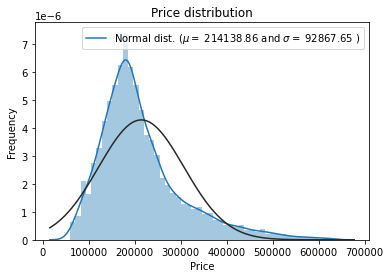

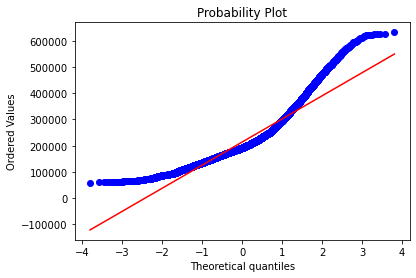

In [33]:
#нормальное распределение целевой переменной
sns.distplot(train['Price'], fit=norm)

mu, sigma = norm.fit(train['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['Price'], plot=plt)
plt.show()

mu = 214138.86 and sigma = 92867.65


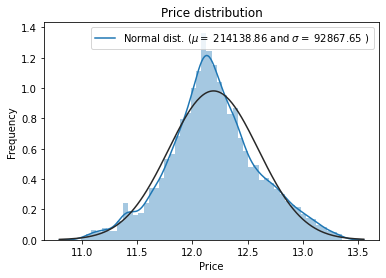

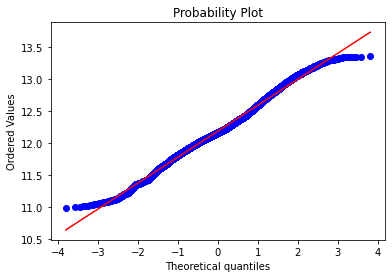

In [34]:
#Журнал распределения целевой переменной
price_log = np.log1p(train['Price'])
sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(train['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

Text(0.5, 1.0, 'Distribution of variable House Year')

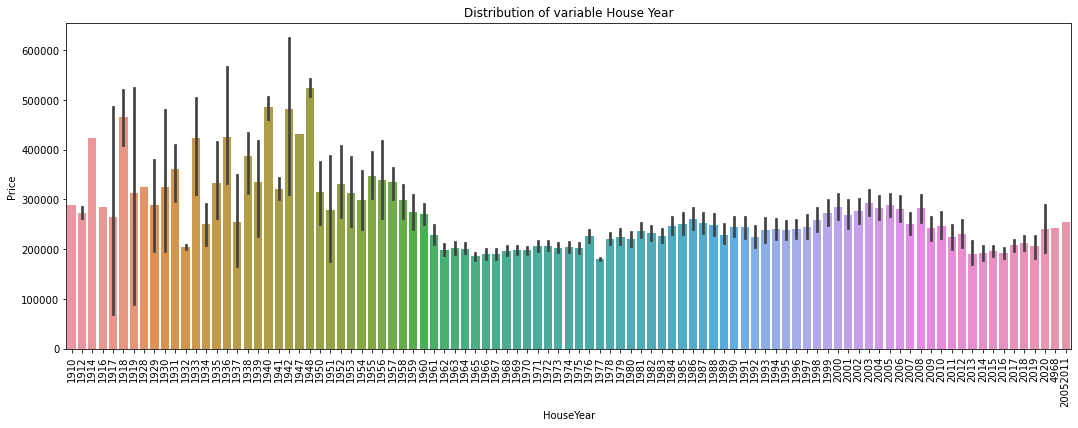

In [35]:
#распределение переменной год постройки дома
plt.figure(figsize=(18, 6))
sns.barplot(train['HouseYear'], train['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable House Year')

Text(0.5, 1.0, 'Distribution of variable District Id')

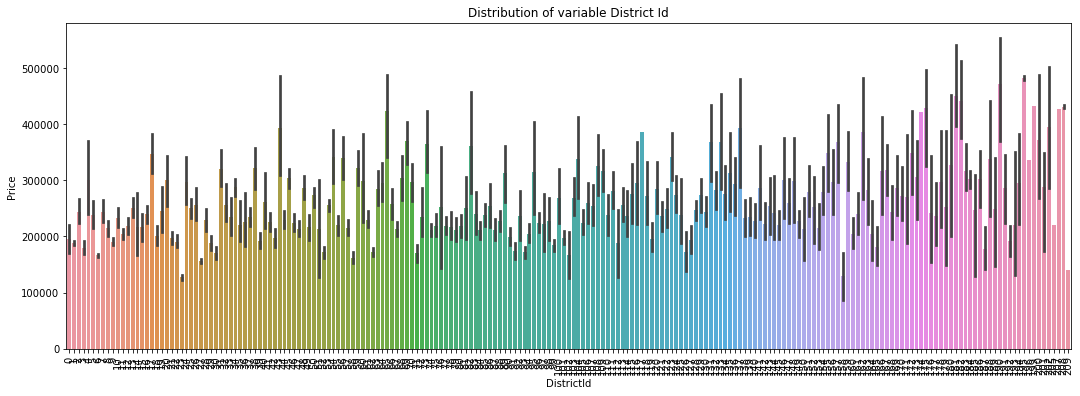

In [36]:
#Распределение переменной id округа
plt.figure(figsize=(18, 6))
sns.barplot(train['DistrictId'], train['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable District Id')

In [37]:
#потерянные данные
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [38]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data

,Missing Ratio
Healthcare_1,47.833333
LifeSquare,21.026667


In [40]:
def df_del_missing(df):
    df_na = (df.isnull().sum() / len(df)) * 100

    df_na = df_na.drop(
        df_na[df_na == 0].index).sort_values(ascending=False)
    df_na = list(df_na.index)
    df.drop(df_na, axis=1, inplace=True)
    return df

Корреляция данных

<AxesSubplot:>

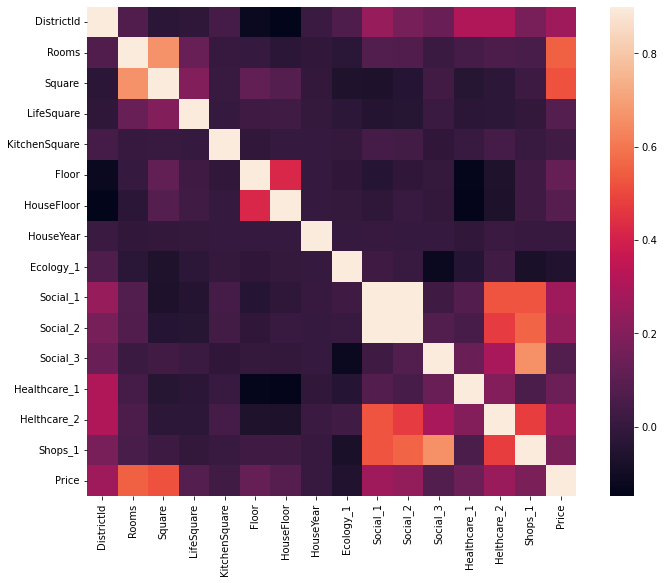

In [41]:
corrmat = train.loc[:, train.columns != 'Id'].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

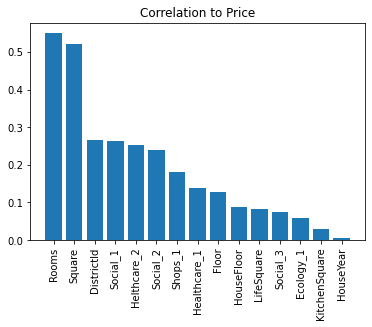

In [42]:
corrmat = train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

In [43]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3,115.027313,NaN,10.0,4,10,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1,39.832523,23.169222,8.0,7,8,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3,78.342216,47.671970,10.0,2,17,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1,40.409908,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2,64.285065,38.562515,9.0,16,16,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


Кластер

In [44]:
scaler = MinMaxScaler()

In [45]:
train_cluster = train.copy()

In [46]:
train_cluster = df_fix_house_year_manual(train_cluster)

In [47]:
train_cluster_scaled = pd.DataFrame(scaler.fit_transform(
    train_cluster.loc[:, ['HouseYear', 'Price']]), columns=['HouseYear', 'Price'])

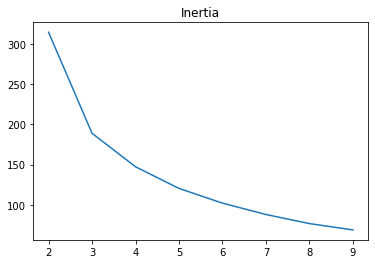

In [48]:
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(train_cluster_scaled)
    temp_inertia = temp_model.inertia_
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)
plt.title('Inertia')

plt.show()

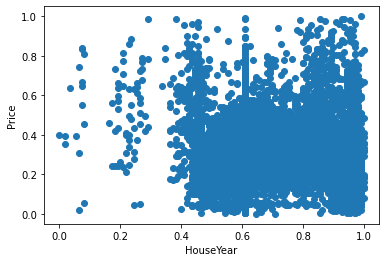

In [49]:
plt.scatter(train_cluster_scaled['HouseYear'], train_cluster_scaled['Price'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.show()

In [50]:
kmeans_model = KMeans(n_clusters=5, random_state=100)

In [51]:
train_labels = kmeans_model.fit_predict(train_cluster_scaled)

Text(0.5, 1.0, 'Train data')

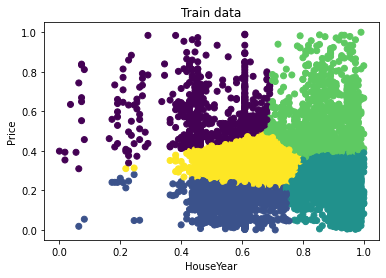

In [52]:
plt.scatter(train_cluster_scaled['HouseYear'],
            train_cluster_scaled['Price'], c=train_labels)

plt.xlabel('HouseYear')
plt.ylabel('Price')

plt.title('Train data')

In [53]:
agglomerative_clustering_model = AgglomerativeClustering(n_clusters=5)

In [54]:
train_cluster['cluster_year'] = agglomerative_clustering_model.fit_predict(
    train_cluster_scaled)

Text(0.5, 1.0, 'Train')

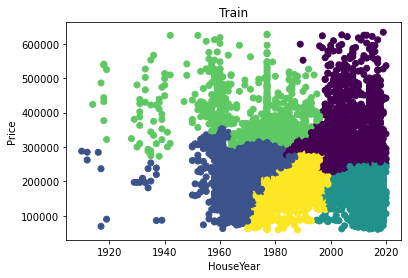

In [55]:
plt.scatter(train_cluster['HouseYear'],
            train_cluster['Price'], c=train_cluster['cluster_year'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.title('Train')

In [56]:
def add_cluster_year(df):
    df_scaled = pd.DataFrame(scaler.fit_transform(
        df.loc[:, ['HouseYear']]), columns=['HouseYear'])
    df['cluster_year'] = agglomerative_clustering_model.fit_predict(df_scaled)
    return df

Средняя цена по количеству комнат и средняя цена по округу и количеству комнат

In [57]:
def add_mean_price(df, df_train=train):
    price = df_train['Price'].mean()
    price_mean_by_rooms = df_train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_by_rooms'})

    price_mean_by_distr_rooms = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_dr'})

    df = pd.merge(df, price_mean_by_distr_rooms, on=[
                  'DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_by_rooms'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price)
    df['mean_price_by_rooms'] = df['mean_price_by_rooms'].fillna(price)
    return df

Для большого района

In [58]:
def add_distr_info(df):
    distr_info = df['DistrictId'].value_counts().reset_index().\
        rename(columns={"index": "DistrictId", "DistrictId": 'large_district'})
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    df['large_district'] = df['large_district'].fillna(1)
    return df

# Моделирование

Функции моделирования

In [59]:
def data_prepare(df, df_train=train):
    df = df_fix_square_manual(df)
    df = df_fix_house_year_manual(df)
    df = df_fix_room(df)
    df = df_fix_square(df)
    df = prepare_lifesquare(df)
    df = fillna_life_square(df)
    df = df_del_missing(df)
    df = add_cluster_year(df)
    df = add_mean_price(df, df_train)
    df = add_distr_info(df)
    df = pd.get_dummies(df)
    df.drop('mean_square_per_room_in_dr', axis=1, inplace=True)
    df.drop('mean_square_rooms_dr', axis=1, inplace=True)
    optimizing_df(df)
    return df


def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()


def model_top_deviation(model, test, valid):
    model_pred = model.predict(test)
    model_test = test.copy()
    model_test['Price'] = model_pred
    model_test['Price_test'] = valid
    model_test['SD'] = abs(model_test['Price']
                           - model_test['Price_test'])
    return model_test.nlargest(10, 'SD')

импортируем необходимые метрики

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

Обрабатываем данные

In [63]:
print(train.columns)

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')


In [64]:
features = list(train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:].index)

target = 'Price'

In [65]:
train[features].head()

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,HouseYear
0,3,115.027313,27,11,0,3097,0,NaN,4,10,NaN,0,0.075424,10.0,2014
1,1,39.832523,22,30,1,6207,0,1183.0,7,8,23.169222,1,0.118537,8.0,1966
2,3,78.342216,1,33,3,5261,1,240.0,2,17,47.671970,0,0.025609,10.0,1988
3,1,40.409908,1,1,0,264,1,NaN,10,22,NaN,0,0.007122,1.0,1977
4,2,64.285065,94,33,0,8667,6,NaN,16,16,38.562515,2,0.282798,9.0,1972


In [66]:
models_dict = {}

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.3, random_state=42)

In [68]:
X_train = data_prepare(X_train, train)
X_test = data_prepare(X_test, train)

In [69]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 6999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                7000 non-null   uint8  
 1   Square               7000 non-null   float32
 2   DistrictId           7000 non-null   uint8  
 3   Social_1             7000 non-null   uint8  
 4   Helthcare_2          7000 non-null   uint8  
 5   Social_2             7000 non-null   uint16 
 6   Shops_1              7000 non-null   uint8  
 7   Floor                7000 non-null   uint8  
 8   HouseFloor           7000 non-null   uint8  
 9   LifeSquare           7000 non-null   float32
 10  Social_3             7000 non-null   uint8  
 11  Ecology_1            7000 non-null   float32
 12  KitchenSquare        7000 non-null   float32
 13  HouseYear            7000 non-null   uint16 
 14  cluster_year         7000 non-null   uint8  
 15  mean_price_dr        7000 non-null   f

In [70]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                3000 non-null   uint8  
 1   Square               3000 non-null   float32
 2   DistrictId           3000 non-null   uint8  
 3   Social_1             3000 non-null   uint8  
 4   Helthcare_2          3000 non-null   uint8  
 5   Social_2             3000 non-null   uint16 
 6   Shops_1              3000 non-null   uint8  
 7   Floor                3000 non-null   uint8  
 8   HouseFloor           3000 non-null   uint8  
 9   LifeSquare           3000 non-null   float32
 10  Social_3             3000 non-null   uint8  
 11  Ecology_1            3000 non-null   float32
 12  KitchenSquare        3000 non-null   float32
 13  HouseYear            3000 non-null   uint16 
 14  cluster_year         3000 non-null   uint8  
 15  mean_price_dr        3000 non-null   f

In [71]:
X_train.head()

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district
0,1,38.234364,31,23,0,3684,4,6,3,20.008121,2,0.000000,8.0,1977,3,234734.109375,159850.796875,40
1,1,31.309444,11,28,2,6533,5,1,5,24.479166,1,0.038693,5.0,1969,0,159161.390625,159850.796875,88
2,2,47.234447,123,47,3,11319,5,2,12,19.363581,0,0.000000,6.0,1980,1,313771.312500,215256.312500,18
3,3,63.841679,61,52,1,10311,9,9,12,38.098614,6,0.300323,8.0,1983,1,274123.468750,289337.968750,81
4,1,36.054333,27,4,0,915,0,15,17,34.296082,0,0.011654,1.0,2016,4,122710.742188,159850.796875,594


In [72]:
y_train.head()

9069    251801.843750
2603    134975.000000
7738    153924.156250
1579    313853.968750
5058    113608.078125
Name: Price, dtype: float32

Линейная регрессия

In [73]:
line_regression_model = LinearRegression()
line_regression_model.fit(X_train, y_train)

LinearRegression()

In [74]:
models_dict['Linear Regression'] = line_regression_model

Тест линейной регрессии

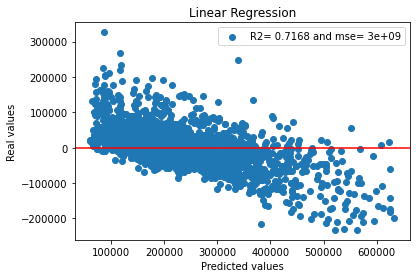

In [75]:
model_test(line_regression_model, 'Linear Regression', X_test, y_test)

In [76]:
model_top_deviation(line_regression_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
1026,1,34.382664,29,31,1,6119,2,7,9,22.438042,...,0.069660,5.0,1965,2,146802.281250,159850.796875,27,134331.46875,624156.000000,489824.53125
2963,1,42.456928,23,6,0,1437,2,7,17,36.527630,...,0.075779,1.0,1977,0,100961.812500,159850.796875,175,106562.28125,554809.437500,448247.15625
940,1,50.299168,9,11,0,2370,1,11,16,24.349604,...,0.136244,9.0,2006,1,141847.359375,159850.796875,89,167780.34375,608674.125000,440893.78125
347,2,62.646122,27,2,0,629,0,4,1,36.527630,...,0.072158,1.0,1977,0,166014.062500,215256.312500,257,165692.15625,593618.750000,427926.59375
2540,5,183.382278,13,74,5,19083,15,2,6,100.985504,...,0.090799,15.0,1997,1,528831.562500,410431.593750,30,637730.00000,212589.703125,425140.31250
2906,3,129.475021,17,23,2,4635,4,17,20,36.527630,...,0.093443,10.0,1977,0,419768.781250,289337.968750,20,521006.40625,111787.078125,409219.31250
858,1,40.279987,27,9,0,1892,1,8,15,38.652657,...,0.211401,10.0,2018,3,122710.742188,159850.796875,257,120726.65625,524279.250000,403552.59375
964,5,118.871948,78,21,1,4346,2,15,16,69.023506,...,0.092291,10.0,1998,1,496026.656250,410431.593750,10,519056.59375,119853.828125,399202.75000
2436,1,38.704697,22,49,3,11395,4,9,22,21.993610,...,0.133215,10.0,1991,0,162263.906250,159850.796875,18,180121.71875,573999.437500,393877.71875
106,2,44.537441,10,33,0,8667,6,8,9,32.103275,...,0.282798,5.0,1971,2,226197.562500,215256.312500,20,192554.40625,574631.312500,382076.90625


Случайная регрессия лесов

In [77]:
random_forest_regressor_model = RandomForestRegressor()
random_forest_regressor_model.fit(X_train, y_train)

RandomForestRegressor()

In [78]:
models_dict['Random Forest Regressor'] = random_forest_regressor_model

Тест случайной регрессии лесов

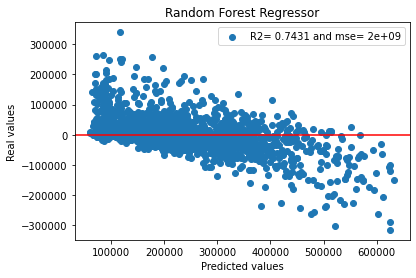

In [79]:
model_test(random_forest_regressor_model,
           'Random Forest Regressor', X_test, y_test)

In [80]:
model_top_deviation(random_forest_regressor_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
1026,1,34.382664,29,31,1,6119,2,7,9,22.438042,...,0.069660,5.0,1965,2,146802.281250,159850.796875,27,132008.701484,624156.000000,492147.298516
940,1,50.299168,9,11,0,2370,1,11,16,24.349604,...,0.136244,9.0,2006,1,141847.359375,159850.796875,89,144125.464844,608674.125000,464548.660156
2963,1,42.456928,23,6,0,1437,2,7,17,36.527630,...,0.075779,1.0,1977,0,100961.812500,159850.796875,175,120322.813047,554809.437500,434486.624453
858,1,40.279987,27,9,0,1892,1,8,15,38.652657,...,0.211401,10.0,2018,3,122710.742188,159850.796875,257,102763.844062,524279.250000,421515.405938
1559,3,106.867638,146,16,3,3893,10,4,22,64.341759,...,0.236108,14.0,2011,3,465889.093750,289337.968750,7,546464.371250,151073.703125,395390.668125
2436,1,38.704697,22,49,3,11395,4,9,22,21.993610,...,0.133215,10.0,1991,0,162263.906250,159850.796875,18,186045.083125,573999.437500,387954.354375
964,5,118.871948,78,21,1,4346,2,15,16,69.023506,...,0.092291,10.0,1998,1,496026.656250,410431.593750,10,505171.281562,119853.828125,385317.453437
347,2,62.646122,27,2,0,629,0,4,1,36.527630,...,0.072158,1.0,1977,0,166014.062500,215256.312500,257,214574.579219,593618.750000,379044.170781
68,1,41.358940,93,25,0,6149,0,7,16,22.449837,...,0.521867,9.0,1987,0,143967.718750,159850.796875,22,148559.234609,526817.562500,378258.327891
106,2,44.537441,10,33,0,8667,6,8,9,32.103275,...,0.282798,5.0,1971,2,226197.562500,215256.312500,20,202557.788750,574631.312500,372073.523750


In [ ]:
Gradient Boosting Regressor

In [81]:
gradient_boosting_regressor_model = GradientBoostingRegressor()
gradient_boosting_regressor_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [82]:
models_dict['Gradient Boosting Regressor'] = gradient_boosting_regressor_model

Тест Gradient Boosting Regressor

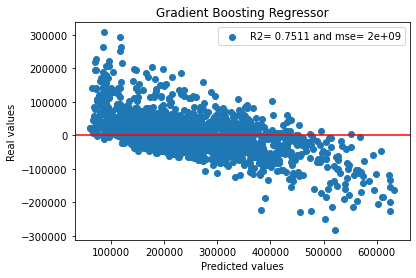

In [83]:
model_test(gradient_boosting_regressor_model,
           'Gradient Boosting Regressor', X_test, y_test)

In [84]:
model_top_deviation(gradient_boosting_regressor_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
1026,1,34.382664,29,31,1,6119,2,7,9,22.438042,...,0.069660,5.0,1965,2,146802.281250,159850.796875,27,142365.680935,624156.000000,481790.319065
940,1,50.299168,9,11,0,2370,1,11,16,24.349604,...,0.136244,9.0,2006,1,141847.359375,159850.796875,89,157559.234632,608674.125000,451114.890368
2963,1,42.456928,23,6,0,1437,2,7,17,36.527630,...,0.075779,1.0,1977,0,100961.812500,159850.796875,175,119917.483518,554809.437500,434891.953982
347,2,62.646122,27,2,0,629,0,4,1,36.527630,...,0.072158,1.0,1977,0,166014.062500,215256.312500,257,169553.734831,593618.750000,424065.015169
858,1,40.279987,27,9,0,1892,1,8,15,38.652657,...,0.211401,10.0,2018,3,122710.742188,159850.796875,257,115536.119117,524279.250000,408743.130883
2436,1,38.704697,22,49,3,11395,4,9,22,21.993610,...,0.133215,10.0,1991,0,162263.906250,159850.796875,18,170966.866901,573999.437500,403032.570599
964,5,118.871948,78,21,1,4346,2,15,16,69.023506,...,0.092291,10.0,1998,1,496026.656250,410431.593750,10,509404.921900,119853.828125,389551.093775
2663,2,68.983444,23,0,0,168,0,1,3,67.122673,...,0.034656,0.0,2014,3,135324.359375,215256.312500,175,124276.130580,506175.000000,381898.869420
68,1,41.358940,93,25,0,6149,0,7,16,22.449837,...,0.521867,9.0,1987,0,143967.718750,159850.796875,22,146607.915650,526817.562500,380209.646850
106,2,44.537441,10,33,0,8667,6,8,9,32.103275,...,0.282798,5.0,1971,2,226197.562500,215256.312500,20,203619.212358,574631.312500,371012.100142


LassoCV

In [85]:
lasso_cv_model = LassoCV()
lasso_cv_model.fit(X_train, y_train)

LassoCV()

In [86]:
models_dict['LassoCV'] = lasso_cv_model

Тест LassoCV

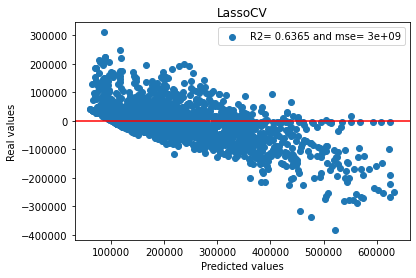

In [87]:
model_test(lasso_cv_model, 'LassoCV', X_test, y_test)

In [88]:
model_top_deviation(lasso_cv_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
1026,1,34.382664,29,31,1,6119,2,7,9,22.438042,...,0.069660,5.0,1965,2,146802.281250,159850.796875,27,146990.953125,624156.000000,477165.06250
940,1,50.299168,9,11,0,2370,1,11,16,24.349604,...,0.136244,9.0,2006,1,141847.359375,159850.796875,89,142098.328125,608674.125000,466575.81250
2963,1,42.456928,23,6,0,1437,2,7,17,36.527630,...,0.075779,1.0,1977,0,100961.812500,159850.796875,175,101726.835938,554809.437500,453082.59375
347,2,62.646122,27,2,0,629,0,4,1,36.527630,...,0.072158,1.0,1977,0,166014.062500,215256.312500,257,165961.171875,593618.750000,427657.56250
2436,1,38.704697,22,49,3,11395,4,9,22,21.993610,...,0.133215,10.0,1991,0,162263.906250,159850.796875,18,162258.171875,573999.437500,411741.25000
858,1,40.279987,27,9,0,1892,1,8,15,38.652657,...,0.211401,10.0,2018,3,122710.742188,159850.796875,257,123202.312500,524279.250000,401076.93750
68,1,41.358940,93,25,0,6149,0,7,16,22.449837,...,0.521867,9.0,1987,0,143967.718750,159850.796875,22,144192.031250,526817.562500,382625.53125
2754,2,54.509392,13,74,5,19083,15,12,17,34.357174,...,0.090799,9.0,2002,1,231706.984375,215256.312500,30,230828.140625,610557.375000,379729.25000
964,5,118.871948,78,21,1,4346,2,15,16,69.023506,...,0.092291,10.0,1998,1,496026.656250,410431.593750,10,491824.500000,119853.828125,371970.68750
2663,2,68.983444,23,0,0,168,0,1,3,67.122673,...,0.034656,0.0,2014,3,135324.359375,215256.312500,175,135657.343750,506175.000000,370517.65625


In [89]:
all_data.loc[all_data['KitchenSquare'] < 3]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3,2352,1,1,40.409908,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B
8,9951,1,1,46.887894,44.628132,1.0,12,20,1977,0.007122,B,B,1,264,0,NaN,0,1,B
9,8094,6,3,79.867477,75.085129,1.0,3,17,2014,0.243205,B,B,5,1564,0,540.0,0,0,B
18,4581,1,1,47.582481,NaN,1.0,16,16,1977,0.007122,B,B,1,264,0,NaN,0,1,B
19,367,45,1,42.367290,40.012527,1.0,16,14,2015,0.195781,B,B,23,5212,6,NaN,3,2,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14986,10616,1,2,77.463539,NaN,1.0,5,16,2017,0.007122,B,B,1,264,0,NaN,0,1,B
14988,11890,1,2,66.683296,NaN,1.0,6,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B
14989,13069,1,2,61.747208,NaN,0.0,5,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B
14993,14676,6,1,48.435108,NaN,1.0,18,25,1977,0.243205,B,B,5,1564,0,540.0,0,0,B


# Результаты

In [91]:
#загрузим необходимые метрики
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [92]:
#загрузим необходимую функцию
def models_r2(models, test, valid):
    scores = pd.DataFrame(columns=['name', 'r2', 'mse'])
    for name, model in models.items():
        test_pred = model.predict(test)
        r2 = r2_score(valid, test_pred)
        mse = mean_squared_error(valid, test_pred)
        scores = scores.append(
            {'name': name, 'r2': r2, 'mse': mse}, ignore_index=True)
    scores.sort_values('r2', ascending=False, inplace=True)
    return scores

Определим лучшую модель

In [93]:
models_score_test = models_r2(models_dict, X_test, y_test)
models_score_train = models_r2(models_dict, X_train, y_train)

In [94]:
models_score_test[['name', 'r2']]

,name,r2
2,Gradient Boosting Regressor,0.751098
1,Random Forest Regressor,0.743074
0,Linear Regression,0.716769
3,LassoCV,0.636461


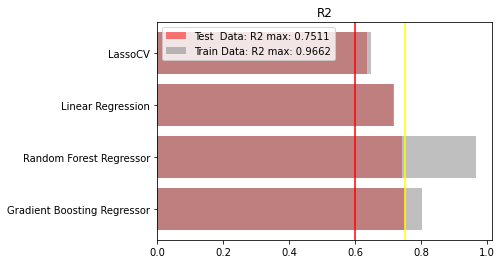

In [95]:
r2_max_test = models_score_test['r2'].max()
r2_max_train = models_score_train['r2'].max()
plt.barh(models_score_test['name'], models_score_test['r2'],
         alpha=0.5, color='red', label=f'Test  Data: R2 max: {r2_max_test:.4f}')
plt.barh(models_score_train['name'], models_score_train['r2'],
         alpha=0.5, color='grey', label=f'Train Data: R2 max: {r2_max_train:.4f}')
plt.title('R2')
plt.legend()
plt.axvline(0.6, color='red')
plt.axvline(r2_max_test, color='yellow')
plt.show()

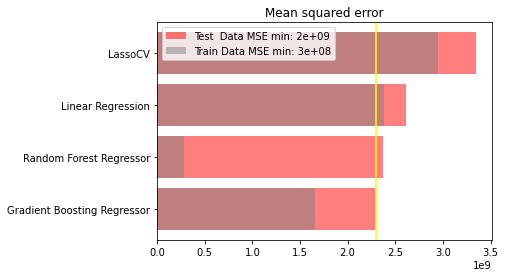

In [96]:
mse_min_test = models_score_test['mse'].min()
mse_min_train = models_score_train['mse'].min()
plt.barh(models_score_test['name'], models_score_test['mse'],
         alpha=0.5, color='red', label=f'Test  Data MSE min: {mse_min_test:.0e}')
plt.barh(models_score_train['name'], models_score_train['mse'],
         alpha=0.5, color='grey', label=f'Train Data MSE min: {mse_min_train:.0e}')
plt.title('Mean squared error')
plt.legend(loc=2)
plt.axvline(mse_min_test, color='yellow')
plt.show()

лучшая модель - Gradient Boosting Regressor

In [105]:
best_model = models_dict['Gradient Boosting Regressor']

In [106]:
pd.DataFrame({'name': list(X_train.columns),
              'importances': list(best_model.feature_importances_)})

,name,importances
0,Rooms,0.006242
1,Square,0.110650
2,DistrictId,0.004115
3,Social_1,0.008113
4,Helthcare_2,0.001812
5,Social_2,0.002009
6,Shops_1,0.001527
7,Floor,0.010599
8,HouseFloor,0.008571
9,LifeSquare,0.001466


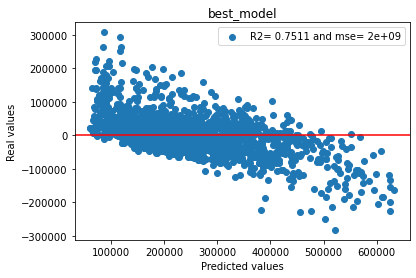

In [107]:
model_test(best_model, 'best_model', X_test, y_test)

# Вывод файлов

In [100]:
test = data_prepare(test)

In [101]:
test_features = list(X_train.columns)

In [102]:
test[test_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                5000 non-null   uint8  
 1   Square               5000 non-null   float32
 2   DistrictId           5000 non-null   uint8  
 3   Social_1             5000 non-null   uint8  
 4   Helthcare_2          5000 non-null   uint8  
 5   Social_2             5000 non-null   uint16 
 6   Shops_1              5000 non-null   uint8  
 7   Floor                5000 non-null   uint8  
 8   HouseFloor           5000 non-null   uint8  
 9   LifeSquare           5000 non-null   float32
 10  Social_3             5000 non-null   uint8  
 11  Ecology_1            5000 non-null   float32
 12  KitchenSquare        5000 non-null   float32
 13  HouseYear            5000 non-null   uint16 
 14  cluster_year         5000 non-null   uint8  
 15  mean_price_dr        5000 non-null   f

In [108]:
test['Price'] = best_model.predict(test[test_features])

mu = 217178.77 and sigma = 77303.53


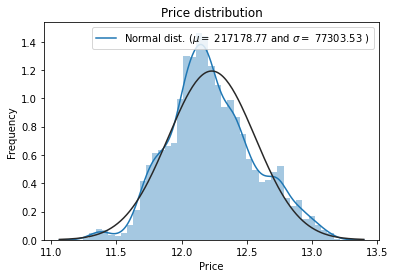

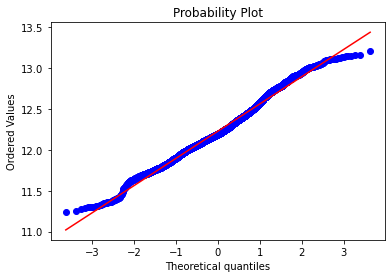

In [109]:
price_log = np.log1p(test['Price'])
sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(test['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

In [111]:
test[['Id', 'Price']].to_csv('Streltsova_predictions.csv', index=None)